### Optimal control of phenomenological models, e.g. the model model
This notebook shows how to compute the optimal control (OC) signal for the FHN model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
model = FHNModel()
model = HopfModel()    # OC can be computed for the Hopf model completely analogously

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 1.
amplitude = 1.
period = duration

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
if model.name == 'fhn':
    x_init, y_init = 0., 0.
elif model.name == 'hopf':
    x_init, y_init = -1.0507332990914269,  -0.2315292520774167
    model.params.x_ou_mean = -1

model.params["xs_init"] = np.array([[x_init]])
model.params["ys_init"] = np.array([[y_init]])

-0.2315292520774171


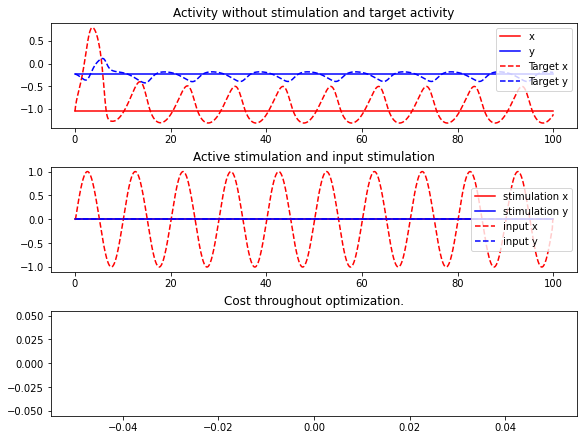

In [3]:
# We set the stimulus in x and y variables, and run the simulation
model.params["x_ext"] = input.copy()
model.params["y_ext"] = zero_input.copy()
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
print(state[0,1,-1])

plot_oc_singlenode(duration, dt, state, target, control, target_input)

In [4]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["x_ext"] = zero_input.copy()
model.params["y_ext"] = zero_input.copy()

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=[1,2,3,4,5,100,200,300,400,500])
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=[1,2,3,4,5,100,200,300,400,500])

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(5)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system


/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'interval' of function 'precision_cost'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "neurolib/optimal_control/cost_functions.py", line 6:
@numba.njit
def precision_cost(x_target, x_sim, w_p, N, precision_matrix, interval=(0, None)):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cost in iteration 0: 97.5362796659315


/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'interval' of function 'derivative_precision_cost'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "neurolib/optimal_control/cost_functions.py", line 55:
@numba.njit
def derivative_precision_cost(x_target, x_sim, w_p, precision_matrix, interval=(0, None)):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[ 0.         -0.11478624 -0.13229438 -0.14868008]
[0.         0.22011227 0.2345719  0.24896544]


IndexError: index 1 is out of bounds for axis 0 with size 1

Compute control for a deterministic system
Cost in iteration 0: 0.005100762298505349
Cost in iteration 1: 0.005100620374027713
Cost in iteration 2: 0.0050997364535044325
Cost in iteration 3: 0.005099608200668255
Cost in iteration 4: 0.005098723691150472
Cost in iteration 5: 0.005098608935550242
Cost in iteration 100: 0.0050626841986075935
Final cost : 0.0050626841986075935


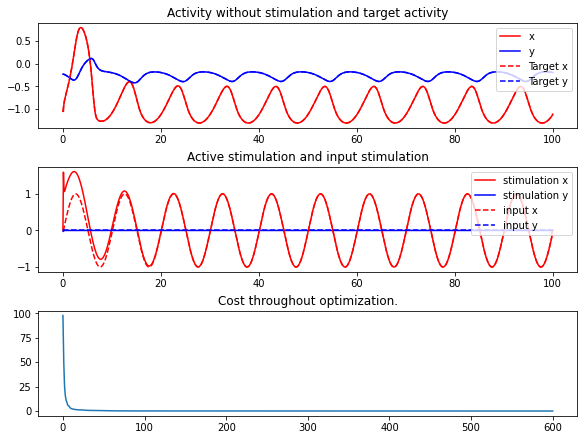

In [ ]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(1)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of FHN oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

xs init -1.1636461406585998
xs init -1.1636461406585998
xs init -1.1636461406585998


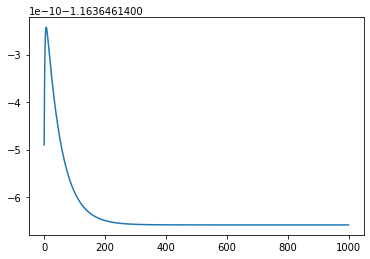

-1.1636461404903033 -1.1636461406585998
xs init -1.1636461406585998
-1.24477372363938
-1.1636461406585998
-0.18658424114911804
-0.20319311996665057


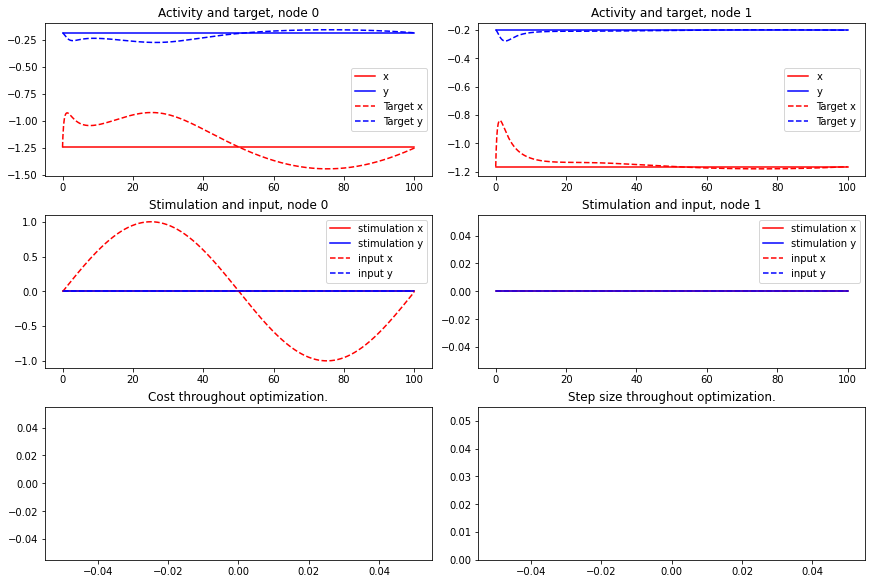

In [51]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

if model.name == 'fhn':
    model = FHNModel(Cmat=cmat, Dmat=dmat)
elif model.name == 'hopf':
    model = HopfModel(Cmat=cmat, Dmat=dmat)    

model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    model.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

model.params["duration"] = duration

if model.name == 'fhn':
    model.params["xs_init"] = np.vstack( [x_init, x_init] )
    model.params["ys_init"] = np.vstack( [y_init, y_init] )
elif model.name == 'hopf':
    model.params["xs_init"] = np.vstack( [-1.24477372363938, -1.1636461406585998] )
    model.params["ys_init"] = np.vstack( [-0.18658424114911804, -0.20319311996665057] )
    print('xs init', model.params["xs_init"][1,0])
    model.params.x_ou_mean = -1.

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

print('xs init', model.params["xs_init"][1,0])

model.run()

print('xs init', model.params["xs_init"][1,0])

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plt.plot(model.x[1,:])
plt.show()
print(model.x[1,0], model.x[1,-1])
print('xs init', model.params["xs_init"][1,0])

print(state[0,0,-1])
print(state[1,0,-1])
print(state[0,1,-1])
print(state[1,1,-1])

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

In [13]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

model_controlled.step = 10.
model_controlled.optimize(1)

state = model_controlled.get_xs()
control = model_controlled.control

#plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 2.449955062629681
[-0.00484551 -0.0052848  -0.00561097 -0.00585475]
update input  [0.04845509 0.05284804 0.0561097  0.05854749 0.06036495]
Cost in iteration 1: 2.4331375474074997
Final cost : 2.4331375474074997


Compute control for a deterministic system
Cost in iteration 0: 0.15354494794654122
[-0.00501292 -0.00388366 -0.00259292 -0.00172874]
update input  [8.23539446 8.51436137 7.97714288 7.24414798 6.58855896]
Cost in iteration 1: 0.151942902201563
[-0.00497422 -0.00384187 -0.00255896 -0.00170531]
update input  [8.28513664 8.55278009 8.00273248 7.26120112 6.60161754]
Cost in iteration 2: 0.15036301641610098
[-0.00493618 -0.00380094 -0.0025258  -0.00168251]
update input  [8.33449839 8.59078945 8.02799052 7.27802621 6.61453786]
[-0.00489877 -0.00376082 -0.00249342 -0.0016603 ]
update input  [8.38348612 8.62839769 8.05292474 7.29462922 6.62732402]
[-0.00486199 -0.00372152 -0.00246179 -0.00163867]
update input  [8.43210606 8.66561286 8.07754264 7.3110159  6.63997991]
[-0.00482582 -0.00368299 -0.00243088 -0.00161759]
update input  [8.4803643  8.70244271 8.10185147 7.32719181 6.65250931]
[-0.00479024 -0.00364521 -0.00240068 -0.00159705]
update input  [8.52826673 8.73889482 8.12585822 7.34316229 6

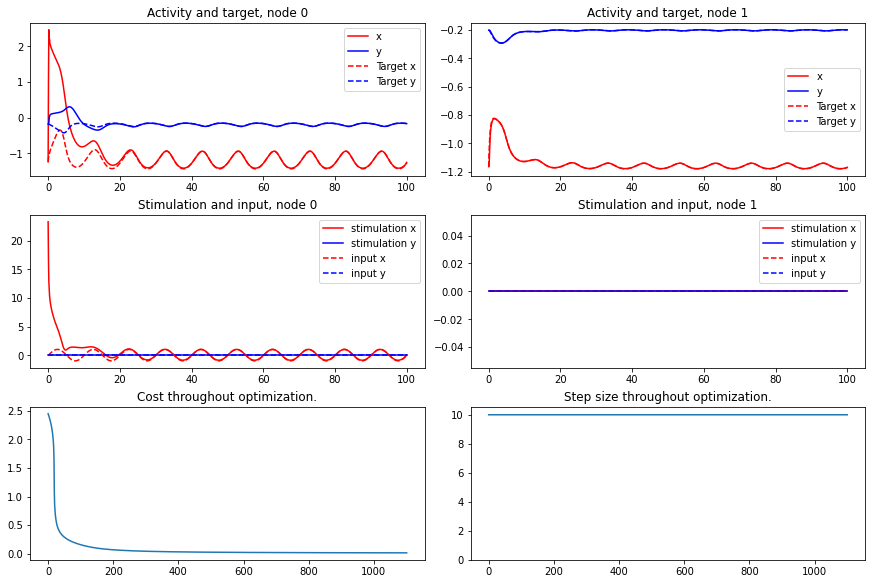

[23.33170339 16.49587639 12.8678027  11.39755966]


In [11]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
# model_controlled.step = 100.
model_controlled.optimize(1000)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)
print(control[0,0,:4])

[0.04845509 0.05284804 0.0561097  0.05854749]


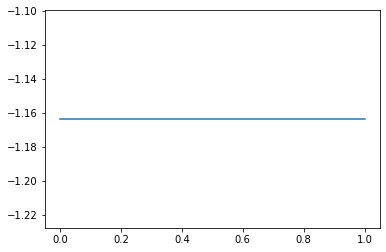

In [14]:
print(model_controlled.model.params["x_ext"][0,:4])

plt.plot(state[1,0,:2])
#plt.plot(target[1,0,:2], linestyle=':')
plt.show()

In [15]:
model_controlled.model.run()
print(model_controlled.model.x[1,:5])

[-1.16364614 -1.16350078 -1.16331706 -1.16314055 -1.16298776]


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

model = HopfModel()
duration = 100.
dt = model.params["dt"]
amplitude = 1.
period = duration

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
